In [1]:
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

In [2]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  #plt.ylim([0, 28000])
  plt.xlabel('Epoch')
  plt.ylabel('Error [requests]')
  plt.legend()
  plt.grid(True)
  return plt.show()

In [3]:
def plot_training(train_labels, train_predictions):
    #a = plt.axes(aspect='equal')
    plt.scatter(range(0,len(train_labels)),train_labels, label="actual")
    plt.scatter(range(0,len(train_predictions)), train_predictions,  label="predicted")
    plt.legend()
    plt.xlabel('Unit Time')
    plt.ylabel('train requests')
    #lims = [0, 1]
    #plt.xlim(lims)
    #plt.ylim(lims)
    #_ = plt.plot()
    return plt.show()
def plot_prediction(test_labels, test_predictions):
    a = plt.axes(aspect='equal')
    plt.scatter(test_labels, test_predictions, color='orange')
    plt.xlabel('True Values requests')
    plt.ylabel('Predictions requests')
    lims = [0, max(list(test_labels)+list(test_predictions))+100]
    plt.xlim(lims)
    plt.ylim(lims)
    _ = plt.plot(lims, lims)
    return plt.show()

In [4]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
from keras import regularizers

def build_and_compile_autoencodermodel(input_shape):
    input_img = keras.Input(shape=(input_shape,))
    #encoded = layers.Dense(512, activation='relu')(input_img)
    #encoded = layers.Dense(256, activation='relu')(encoded)
    #encoded = layers.Dense(128, activation='relu')(encoded)
    #encoded = layers.Dense(64, activation='relu')(encoded)
    encoded = layers.Dense(32, activation='relu')(input_img)
    encoded = layers.Dense(5, activation='relu')(encoded)
    
    decoded = layers.Dense(32, activation='relu')(encoded)
    #decoded = layers.Dense(64, activation='relu')(decoded)
    #decoded = layers.Dense(128, activation='relu')(decoded)
    #decoded = layers.Dense(256, activation='relu')(decoded)
    #decoded = layers.Dense(512, activation='relu')(decoded)
    decoded = layers.Dense(input_shape, activation='sigmoid')(decoded)
    
    #model.compile(loss='mean_absolute_error',
    #            optimizer=tf.keras.optimizers.Adam(0.001))
    
    autoencoder = keras.Model(input_img, decoded)
    autoencoder.compile("adam", loss='mae')

    return autoencoder


def build_and_compile_model(norm):
  model = None
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu',name="dense_one"),
      layers.Dense(64, activation='relu',name="dense_two"),
      layers.Dense(1,name="dense_three")
  ])
  #model.add(layers.Embedding(input_dim=64, output_dim=64))  
  #model.add(layers.LSTM(128))
  #model.add(layers.Dense(1, activation='sigmoid'))  
  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [5]:
cwd = os.getcwd()
output_dir = os.path.join(cwd, "../../data")
df = pd.read_csv(os.path.join(output_dir, "combined_miniodbmysql.csv"))
df_test = pd.read_csv(os.path.join(output_dir, "combined_miniodbmysqltest.csv"))
#df_test = pd.read_csv(os.path.join(output_dir, "figlet1599056546.006096_1599063766.431225.csv"))
df = df.drop(df[df.responsetime > 5].index)
df.pop('Time')
df_test = df_test.drop(df_test[df_test.responsetime > 5].index)
df_test.pop('Time')
df.head()

,cpu,diskio,diskioRead,diskioWritten,mem,networkReceived,networkTransmitted,replica,requests,responsetime,totalcpu,totalcpuUtilization,totalmemory,totalmemoryUtilization
0,0.005656,0.000089,0.0,17931.377778,0.007200,16138.355556,53534.133333,1.0,1.0,2.842053,12.0,5.188889,5.045532e+10,9.907735
1,0.003688,0.000089,0.0,13471.288889,0.007200,16707.733333,50657.800000,1.0,2.0,2.668923,12.0,5.075000,5.045532e+10,9.943913
2,0.316843,0.000000,0.0,21026.133333,0.012803,20102.600000,56847.955556,1.0,3.0,2.667665,12.0,5.075000,5.045532e+10,9.943913
3,0.416394,0.000000,0.0,12196.977778,0.012803,19553.177778,53704.466667,1.0,5.0,2.590923,12.0,5.405556,5.045532e+10,9.902425
4,0.405535,0.000089,0.0,13198.222222,0.013208,19600.688889,56622.866667,1.0,5.0,2.654380,12.0,5.405556,5.045532e+10,9.902425


In [6]:
df_test = df_test.append(df[df.totalcpu > 16])
df = df.drop(df[df.totalcpu > 16].index)

In [7]:
df['total_cpu_util'] = (df['totalcpuUtilization']*(df['totalcpu']*0.67))/100                    
df['total_mem_util'] = (df['totalmemoryUtilization']*df['totalmemory'])*1e-9
df_test['total_cpu_util'] = (df_test['totalcpuUtilization']*(df_test['totalcpu']*0.67))/100
df_test['total_mem_util'] = (df_test['totalmemoryUtilization']*df_test['totalmemory'])*1e-9


df['cpu'] = (df['cpu']*(df['totalcpu']*0.67))/100                    
df['mem'] = (df['mem']*df['totalmemory'])*1e-9
df['networkTransmitted'] = (df['networkTransmitted'])*1e-9


df_test['cpu'] = (df_test['cpu']*(df_test['totalcpu']*0.67))/100
df_test['mem'] = (df_test['mem']*df_test['totalmemory'])*1e-9
df_test['networkTransmitted'] = (df_test['networkTransmitted'])*1e-9



In [8]:
feature_set = ['total_cpu_util', 'total_mem_util', 'responsetime', 'requests', 'networkTransmitted', 'networkReceived', 'diskio', 'diskioRead', 'diskioWritten' ]
selected_feature_set = ['cpu','mem','responsetime', 'networkTransmitted' ]


In [9]:
X_train = df.loc[:,selected_feature_set].values # getting all values as a matrix of dataframe 
y_train = df.pop('requests').values

X_test = df_test.loc[:,selected_feature_set].values # getting all values as a matrix of dataframe 
y_test = df_test.pop('requests')


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 4)                 9         
_________________________________________________________________
dense_one (Dense)            (None, 64)                320       
_________________________________________________________________
dense_two (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_three (Dense)          (None, 1)                 65        
Total params: 4,554
Trainable params: 4,545
Non-trainable params: 9
_________________________________________________________________
None


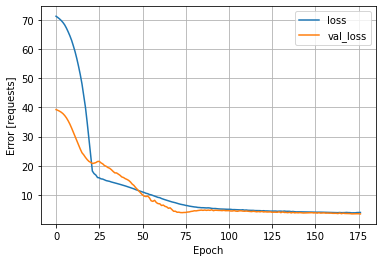

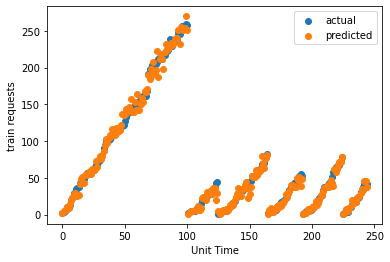

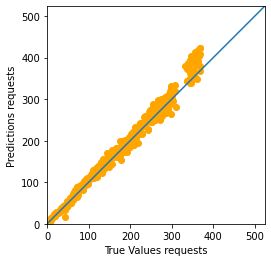

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 4)                 9         
_________________________________________________________________
dense_one (Dense)            (None, 64)                320       
_________________________________________________________________
dense_two (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_three (Dense)          (None, 1)                 65        
Total params: 4,554
Trainable params: 4,545
Non-trainable params: 9
_________________________________________________________________
None


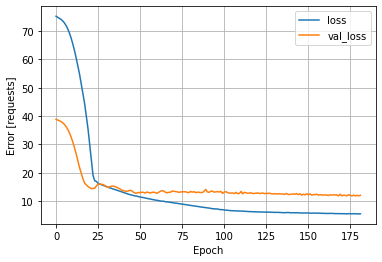

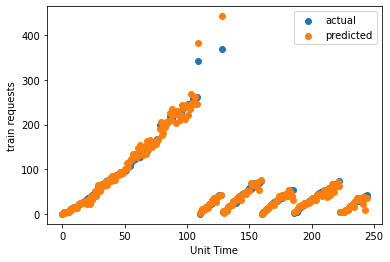

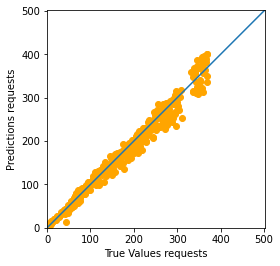

In [10]:
i = 0
loss, score, model = [], [], []
hist = np.empty([6,])
# k fold
kf = KFold(n_splits=2, random_state=42, shuffle=True)

for train_index, vald_index in kf.split(X_train): 
    X_train_split, X_vald_split = X_train[train_index], X_train[vald_index]
    y_train_split, y_vald_split = y_train[train_index], y_train[vald_index]
    
    input = X_train_split
    input_normalizer = preprocessing.Normalization(input_shape=[X_train.shape[1],])
    input_normalizer.adapt(input)
    
    dnn_model = None
    dnn_model = build_and_compile_model(input_normalizer)

    print(dnn_model.summary())

    history = dnn_model.fit(
        X_train_split, y_train_split,
        validation_split=0.02, 
        verbose=0, epochs=6000,callbacks=[callback])
    
    plot_loss(history)
    loss.append(dnn_model.evaluate(X_vald_split, y_vald_split,verbose=0))
    
    ## Make Predictions
    train_predictions = dnn_model.predict(X_train_split).flatten()

    plot_training(y_train_split, train_predictions)
    
    test_predictions = dnn_model.predict(X_test).flatten()
    plot_prediction(y_test, test_predictions)
    
    R = r2_score(y_test, test_predictions)*100
    model.append('dnn_model_'+str(i))
    score.append(R)
    i = i+1
    
model = np.array(model)
score = np.array(score)
loss = np.array(loss)

In [11]:
data = np.array([model, loss, score]).T
pd.DataFrame(data,columns=["model", "loss", "score"])

,model,loss,score
0,dnn_model_0,5.860327243804932,97.89318092171908
1,dnn_model_1,4.822317600250244,97.85539418443537


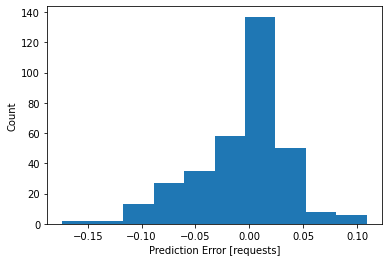

In [12]:
error = (test_predictions.flatten() - y_test)/max(y_test)
plt.hist(error)
plt.xlabel('Prediction Error [requests]')
_ = plt.ylabel('Count')